In [2]:
# Importing the methods and libraries
% matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from helpers import split_data, create_submission_csv, load_data
from plots import plot_raw_data, plot_every_lambda, plot_number_features, plot_min_ratings
from parameter_search import find_min_num_ratings, finding_gamma,finding_lambdas, finding_num_features,finding_weighted_average
from matrix_factorization import matrix_factorization_SGD,ALS
from postprocessing import construct_full_features
from baseline_mean import baseline_global_mean, baseline_user_mean,baseline_item_mean
% load_ext autoreload
% autoreload 2

## Load the Data


Number of items: 1000, Number of users: 10000.


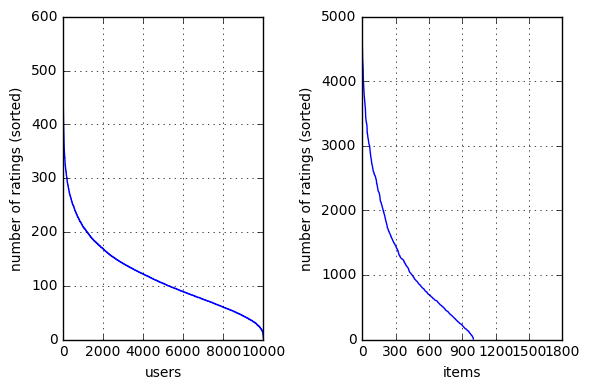

In [3]:
# Load the Data set in Data folder
path_dataset = "../Data/data_train.csv"

# Transpose the data in order to have a shape (num_users, num_items)
ratings = load_data(path_dataset).T
print("Number of items: {}, Number of users: {}.".format(
    ratings.shape[0], ratings.shape[1]))

# Plot the statistics result on raw rating data
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

### Split the data into a train and test set

In [4]:
# Split the data to have a train and a test set
min_num_ratings = 20
valid_ratings, train, test, valid_users, valid_items, train_full, test_full = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings, p_test=0.1)

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1058411
Total number of nonzero elements in test data:116778


### Finding good parameters

#### Optimizing number of ratings

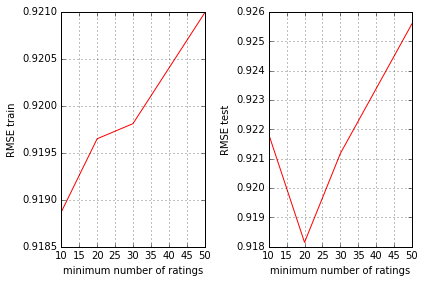

In [5]:
# Plot the RMSE of ALS for different minimum number of ratings fixing other parameters
min_ratings_to_try = [10, 20, 30, 50]
full_item_features_array, full_user_features_array,rmse_train_full, rmse_test_full = find_min_num_ratings(min_ratings_to_try,
                                                                                          ratings, num_items_per_user,
                                                                                          num_users_per_item, 0.1,
                                                                                          0.09, 0.09, 20)
plot_min_ratings(min_ratings_to_try,rmse_train_full,rmse_test_full)

#### Finding a good gamma for SGD

In [6]:
# Find the best gamma for SGD by fixing lambda user/item, number of epochs and k
gamma_array = np.array([0.01, 0.03, 0.05, 0.06, 0.07])
lambda_user=0.15
lambda_item=0.04
num_features=20
rmse_train_array, rmse_test_array = finding_gamma(train, test, gamma_array,lambda_user,lambda_item,num_features)
print("gamma_array:{}".format(gamma_array))
print("lambda user 0.8 lambda item 0.01")
print("rmse_train_array:{}".format(rmse_train_array))
print("rmse_test_array:{}".format(rmse_test_array))

predicting for gamma 0.01
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.042209747436632.
iter: 1, RMSE on training set: 1.013023713486423.
iter: 2, RMSE on training set: 1.002221858810257.
iter: 3, RMSE on training set: 0.9959138164953009.
iter: 4, RMSE on training set: 0.9916053473700887.
iter: 5, RMSE on training set: 0.9891015668694675.
iter: 6, RMSE on training set: 0.9872852705262027.
iter: 7, RMSE on training set: 0.98612236533744.
iter: 8, RMSE on training set: 0.9852766237775653.
iter: 9, RMSE on training set: 0.9844950955931322.
iter: 10, RMSE on training set: 0.98393925491381.
iter: 11, RMSE on training set: 0.9835725121338369.
iter: 12, RMSE on training set: 0.983348227506436.
iter: 13, RMSE on training set: 0.9832930739342297.
iter: 14, RMSE on training set: 0.9831904270539022.
iter: 15, RMSE on training set: 0.9831531672768165.
iter: 16, RMSE on training set: 0.9829225697438356.
iter: 17, RMSE on training set: 0.9829604325104082.
iter: 18, RM

#### Finding a good number of features

In [ ]:
# Plot the RMSE of ALS with respect to the number of features in the matrix factorization
num_features_array = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 240, 280, 320, 360, 400]

rmse_train_array, rmse_test_array, item_features_array, user_features_array = finding_num_features(train, test,
                                                                                                   num_features_array)
print(list(zip(num_features_array, rmse_test_array)))
plot_min_features(num_features_array, rmse_train_array, rmse_test_array)

#### Finding a good lambda

In [ ]:
# Create train/test arrays that contains the RMSE of ALS with different combinations of lambda user and lambda item. 
# We fixed k, the convergence threshold, we trained it 90% of the data and tested on 10%.
lambda_table_user = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
lambda_table_item = np.array(
    [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2])

results_train_lambda, results_test_lambda = finding_lambdas(train, test, lambda_table_user, lambda_table_item, 20)


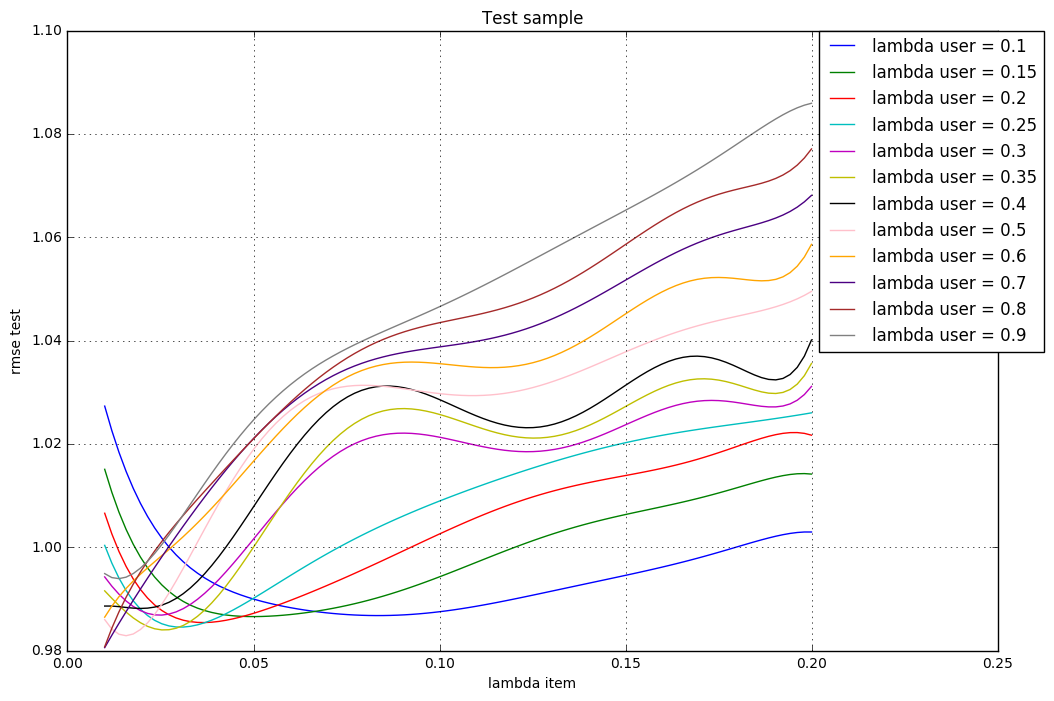

In [8]:
# All the ALS were executed with 3 different computers and we obtained the following values :
results_test_lambda_complete = np.array([
    [1.02759407, 1.01551833, 1.00801167, 1.0020854, 0.99806348,  # lambda_user = 0.1
     0.9950844, 0.99286152, 0.98795459, 0.98685358, 0.98764806,
     0.99005376, 0.99258021, 0.99655324, 0.99989937, 1.0029597],
    [1.01538586, 1.00420938, 0.99741154, 0.99306237, 0.99025728,  # lambda_user = 0.15
     0.98849889, 0.98701754, 0.9866398, 0.98960704, 0.9945488,
     0.99975104, 1.00440176, 1.00812465, 1.0113862, 1.01416642],
    [1.00692633, 0.9968172, 0.99119129, 0.98803177, 0.98640009,  # lambda_user = 0.2
     0.98578441, 0.98547544, 0.98918367, 0.99609117, 1.00284443,
     1.00815487, 1.01252118, 1.01542597, 1.01942391, 1.02168969],
    [1.0007996, 0.99184025, 0.98740458, 0.98541414, 0.98490947,  # lambda_user = 0.25
     0.98537114, 0.98614635, 0.99398507, 1.00274542, 1.00935549,
     1.01384274, 1.01824878, 1.0220176, 1.02369229, 1.02602618],
    [0.99618721, 0.98840893, 0.98544304, 0.98428957, 0.98485497,  # lambda_user = 0.3
     1.00614024, 0.98810463, 0.9992135, 1.03361043, 1.0140108,
     1.01921271, 1.02255006, 1.02545748, 1.02829194, 1.03109047],
    [0.99263679, 0.98632496, 0.98417933, 0.98415944, 0.98573783,  # lambda_user = 0.35
     0.98794064, 0.99117467, 1.00398503, 1.03456632, 1.01872426,
     1.02283928, 1.02556356, 1.02890523, 1.03219892, 1.03546098],
    [0.99018196, 0.98469486, 0.98366111, 1.00242328, 0.98727653,  # lambda_user = 0.4
     0.99063156, 0.99464545, 1.01890835, 1.03549477, 1.02202315,
     1.02539542, 1.02931856, 1.03240793, 1.03616565, 1.03989342],
    [0.98626445, 0.9830615, 0.98403657, 0.98726497, 0.9917705,  # lambda_user = 0.5
     1.00580138, 1.00900763, 1.02079592, 1.03731797, 1.02626409,
     1.03057501, 1.03540659, 1.04015343, 1.04484194, 1.04948934],
    [0.98389823, 0.9997006, 0.98594334, 1.00061031, 1.00425459,  # lambda_user = 0.6
     1.00170267, 1.0097585, 1.0224479, 1.03913499, 1.03055464,
     1.03651561, 1.04231748, 1.04728534, 1.05289198, 1.05845555],
    [0.98258807, 0.98369456, 0.9888138, 1.00224496, 1.00451603,  # lambda_user = 0.7
     1.00834432, 1.01157981, 1.02403968, 1.040967, 1.03557486,
     1.04179904, 1.04850725, 1.0551033, 1.06161811, 1.06807184],
    [0.98203391, 0.98518159, 0.99970089, 0.9986069, 1.00642688,  # lambda_user = 0.8
     1.00988322, 1.01298148, 1.02562964, 1.04282313, 1.03992536,
     1.04781498, 1.05476392, 1.06226109, 1.06967215, 1.07701612],
    [0.99855844, 0.98717726, 0.99493095, 1.00393785, 1.00781921,  # lambda_user = 0.9
     1.01110089, 1.0142171, 1.02723925, 1.04470772, 1.04499421,
     1.05311966, 1.06169123, 1.06945571, 1.07775344, 1.08597568]])

# Plot for every lambda_user its RMSE on the test data with respect to lambda_item
plot_every_lambda(results_test_lambda_complete, lambda_table_user, lambda_table_item)


#### Repartition between ALS with 10 features and ALS with 20 features

In [ ]:
# Computing a first prediction with ALS and k = 10
lambda_user = 0.15
lambda_item = 0.04
k = 10
predicted_user_features_k10, predicted_item_features_k10, error_table, rmse_test = ALS(train, test, lambda_user,
                                                                                       lambda_item, k)

# Computing a second prediction with ALS and k = 20
lambda_user = 0.8
lambda_item = 0.01
k = 20
predicted_user_features_k20, predicted_item_features_k20, error_table, rmse_test = ALS(train, test, lambda_user,
                                                                                       lambda_item, k)

# Computing the weights of the average between the two predictions
predictionk20=predicted_item_features_k20.T @ predicted_user_features_k20
predictionk10=predicted_item_features_k10.T @ predicted_user_features_k10
print("The best weight for the is {}".format(finding_weighted_average(test,predictionk20,predictionk10)))


## Weaker predictions

#### Baseline methods

In [10]:
mean,rmse_train,rmse_test=baseline_global_mean(train,test)
print("The global mean is {}.\nRMSE on train : {}\nRMSE on test : {} \n".format(
    mean,rmse_train,rmse_test))
_,rmse_train,rmse_test=baseline_user_mean(train,test)
print("User mean\nRMSE on train : {}\nRMSE on test : {} \n".format(
    rmse_train,rmse_test))
_,rmse_train,rmse_test=baseline_item_mean(train,test)
print("Item mean\nRMSE on train : {}\nRMSE on test : {} \n".format(
    rmse_train,rmse_test))

The global mean is 3.8575732867477757.
RMSE on train : 1.1191362534801588
RMSE on test : 1.118267219106809 

User mean
RMSE on train : 1.0846173702662243
RMSE on test : 1.0942141456010284 

Item mean
RMSE on train : 1.029450055632703
RMSE on test : 1.028656308663759 



#### SGD

In [22]:
gamma=0.05
lambda_user=0.15
lambda_item=0.04
num_features=20
predicted_user_features, predicted_item_features=matrix_factorization_SGD(train, test,gamma,lambda_user,lambda_item,num_features)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.1189132590496695.
iter: 1, RMSE on training set: 1.066638600444248.
iter: 2, RMSE on training set: 1.0453928441920972.
iter: 3, RMSE on training set: 1.0280637794021092.
iter: 4, RMSE on training set: 1.0120607726838817.
iter: 5, RMSE on training set: 0.9976389359016034.
iter: 6, RMSE on training set: 0.9871887757726008.
iter: 7, RMSE on training set: 0.9761985624164673.
iter: 8, RMSE on training set: 0.9685439465509907.
iter: 9, RMSE on training set: 0.9611930839736158.
iter: 10, RMSE on training set: 0.9553683481090011.
iter: 11, RMSE on training set: 0.9504283644512486.
iter: 12, RMSE on training set: 0.9471945956647462.
iter: 13, RMSE on training set: 0.9442343066484643.
iter: 14, RMSE on training set: 0.9418253581151118.
iter: 15, RMSE on training set: 0.9397154681676936.
iter: 16, RMSE on training set: 0.9379875366618795.
iter: 17, RMSE on training set: 0.9371353212608202.
iter: 18, RMSE on training set:

## Submited Prediction

#### Preparing the data

In [6]:
# This time, we train our prediction on the entire set of ratings so p_test=0
min_num_ratings = 20
valid_ratings, train, test, valid_users, valid_items, train_full, test_full = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings, p_test=0)


Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1175189
Total number of nonzero elements in test data:0


#### ALS

In [7]:
# Computing a first prediction with ALS and k = 10
lambda_user = 0.15
lambda_item = 0.04
k = 10
predicted_user_features_k10, predicted_item_features_k10, error_table, _ = ALS(train, test, lambda_user, lambda_item,
                                                                               k)
# Computing a second prediction with ALS and k = 20
lambda_user = 0.8
lambda_item = 0.01
k = 20
predicted_user_features_k20, predicted_item_features_k20, error_table, _ = ALS(train, test, lambda_user,
                                                                               lambda_item, k)


RMSE on train data: 0.9917956480268035
RMSE on train data: 0.980756389379706
RMSE on train data: 0.9631651131843969
RMSE on train data: 0.9512197580511401
RMSE on train data: 0.9448853421878082
RMSE on train data: 0.9410799417824145
RMSE on train data: 0.9386039327230916
RMSE on train data: 0.9368938460373881
RMSE on train data: 0.9356568893451497
RMSE on train data: 0.9347282988213548
RMSE on train data: 0.9340087943555562
RMSE on train data: 0.9334353524981738
RMSE on train data: 0.9329664151700358
RMSE on train data: 0.9325739123435062
RMSE on train data: 0.9322386550089017
RMSE on train data: 0.9319474806175403
RMSE on train data: 0.9316913634018377
RMSE on train data: 0.9314640975209598
RMSE on train data: 0.9312613555803387
RMSE on train data: 0.9310800171952531
RMSE on train data: 0.9309177033346138
RMSE on train data: 0.9307724700329125
RMSE on train data: 0.9306426229738132
RMSE on train data: 0.9305266186613117
RMSE on train data: 0.9304230219257565
RMSE on train data: 0.9303

In [8]:
# Reconstruct the full features matrices in order to have the matching prediction size
lambda_user = 0.8
lambda_item = 0.01
full_user_features_k20, full_item_features_k20 = construct_full_features(predicted_user_features_k20,
                                                                        predicted_item_features_k20,
                                                                        valid_users, valid_items,
                                                                        min_num_ratings, train_full,
                                                                        lambda_user, lambda_item)
lambda_user = 0.15
lambda_item = 0.04
k = 10
full_user_features_k10, full_item_features_k10 = construct_full_features(predicted_user_features_k10,
                                                                        predicted_item_features_k10,
                                                                        valid_users, valid_items, min_num_ratings,
                                                                        train_full,
                                                                        lambda_user, lambda_item)


In [9]:
# Compute the prediction using the weighted predictions found in the previous two ALS
weight = 0.46
full_prediction_from_two = np.multiply(full_item_features_k20.T @ full_user_features_k20, weight) + np.multiply(
    full_item_features_k10.T @ full_user_features_k10, 1 - weight)


## Submission

In [10]:
# Create the submission file in the current folder
create_submission_csv(full_prediction_from_two, "../Data/sampleSubmission.csv", "./submission.csv")
